# ボールと選手のデータセット分析

このノートブックは、テニスの試合におけるボールと選手両方のアノテーションを含むデータセットを分析します。データはCOCOフォーマットで、以下の特定の規約に従っています。

* **ボール**: 単一のキーポイント `(x, y, v)` と固定サイズのバウンディングボックス（面積=64）でアノテーションされます。
* **選手**: バウンディングボックスと一連のポーズキーポイントでアノテーションされます。

## 1. セットアップ

ライブラリをインポートし、アノテーションファイルを読み込みます。

In [33]:
import json
import random
from pathlib import Path

# cv2の代わりにPillowとmatplotlib.patchesを使用
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns
import cv2

# プロットスタイルの設定
sns.set_style("whitegrid")

In [34]:
# --- パス設定 ---
DATA_DIR = Path("/app/data/processed/ball")
ANNOTATION_FILE = DATA_DIR / "annotation.json"
IMAGE_DIR = DATA_DIR / "images"

# --- アノテーションの読み込み ---
with open(ANNOTATION_FILE, "r") as f:
    coco_data = json.load(f)

# --- データフレームの作成 ---
images_df = pd.DataFrame(coco_data["images"])
annotations_df = pd.DataFrame(coco_data["annotations"])
categories_df = pd.DataFrame(coco_data["categories"])

print("データは正常に読み込まれました。")

データは正常に読み込まれました。


## 2\. データセット概要

データセットの内容の全体像を把握します。

In [35]:
# --- 基本統計 ---
num_images = len(images_df)
num_annotations = len(annotations_df)
num_categories = len(categories_df)

print(f"画像数: {num_images}")
print(f"アノテーション数: {num_annotations}")

# --- カテゴリ詳細 ---
print("\n--- カテゴリ ---")
print(categories_df.to_string())

# --- カテゴリごとにアノテーションを分割 ---
# カテゴリ名とIDを取得
cat_name_to_id = {cat['name']: cat['id'] for cat in coco_data['categories']}
ball_cat_id = cat_name_to_id.get("ball")
player_cat_id = cat_name_to_id.get("player")

ball_anns = annotations_df[annotations_df['category_id'] == ball_cat_id]
player_anns = annotations_df[annotations_df['category_id'] == player_cat_id]

print(f"\nボールのアノテーション数: {len(ball_anns)}")
print(f"選手のアノテーション数: {len(player_anns)}")

画像数: 19106
アノテーション数: 56965

--- カテゴリ ---
   id    name supercategory                                                                                                                                                                                               keypoints                                                                                                                                                                skeleton
0   1    ball        sports                                                                                                                                                                                                [center]                                                                                                                                                                      []
1   2  player        person  [nose, left_eye, right_eye, left_ear, right_ear, left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist, right_wrist, left_hip

## 3\. ボールのアノテーション分析

「ボール」カテゴリのアノテーションを専門的に分析します。

### 3.1. キーポイントの可視性

ボールのキーポイントの可視性ステータスを確認します。

/tmp/ipykernel_80/3918598751.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_anns['visibility'] = ball_anns['keypoints'].apply(get_visibility)


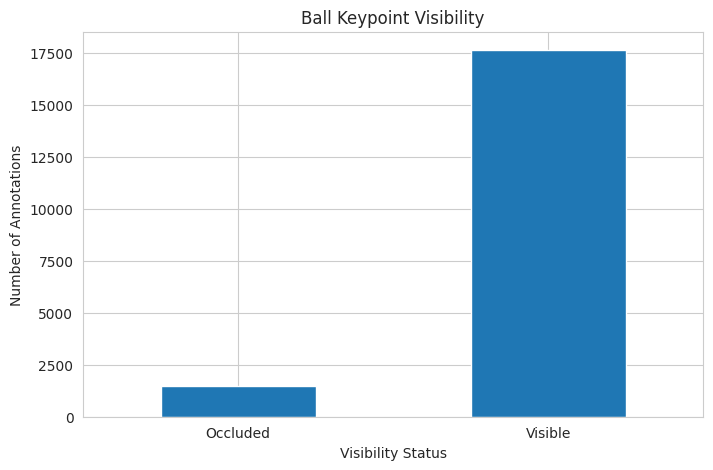

In [36]:
# keypointsリスト [x, y, v] から可視性(v)を抽出する関数
def get_visibility(keypoints):
    if not keypoints:
        return 0
    return keypoints[2]

ball_anns['visibility'] = ball_anns['keypoints'].apply(get_visibility)

visibility_counts = ball_anns['visibility'].value_counts().sort_index()
# Map index to English
visibility_counts.index = visibility_counts.index.map({0: 'Unlabeled', 1: 'Occluded', 2: 'Visible'})

plt.figure(figsize=(8, 5))
visibility_counts.plot(kind='bar', rot=0)
plt.title('Ball Keypoint Visibility')
plt.xlabel('Visibility Status')
plt.ylabel('Number of Annotations')
plt.show()

### 3.2. バウンディングボックスの面積

ボールのバウンディングボックスの面積が64で固定されていることを確認します。

/tmp/ipykernel_80/545996571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_anns['area'] = ball_anns['bbox'].apply(lambda x: x[2] * x[3])


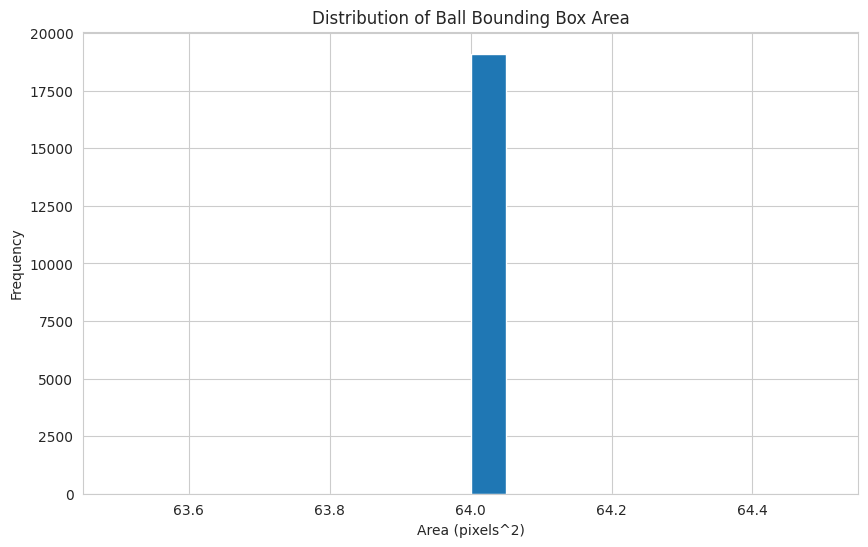

ボールのバウンディングボックス面積のユニークな値: [64]


In [37]:
ball_anns['area'] = ball_anns['bbox'].apply(lambda x: x[2] * x[3])

plt.figure(figsize=(10, 6))
plt.hist(ball_anns['area'], bins=20)
plt.title('Distribution of Ball Bounding Box Area')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Frequency')
plt.show()

print(f"ボールのバウンディングボックス面積のユニークな値: {ball_anns['area'].unique()}")

## 4\. 選手のアノテーション分析

次に、「選手」のアノテーションを分析します。

### 4.1. バウンディングボックスの面積

/tmp/ipykernel_80/2019000058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_anns['area'] = player_anns['bbox'].apply(lambda x: x[2] * x[3])


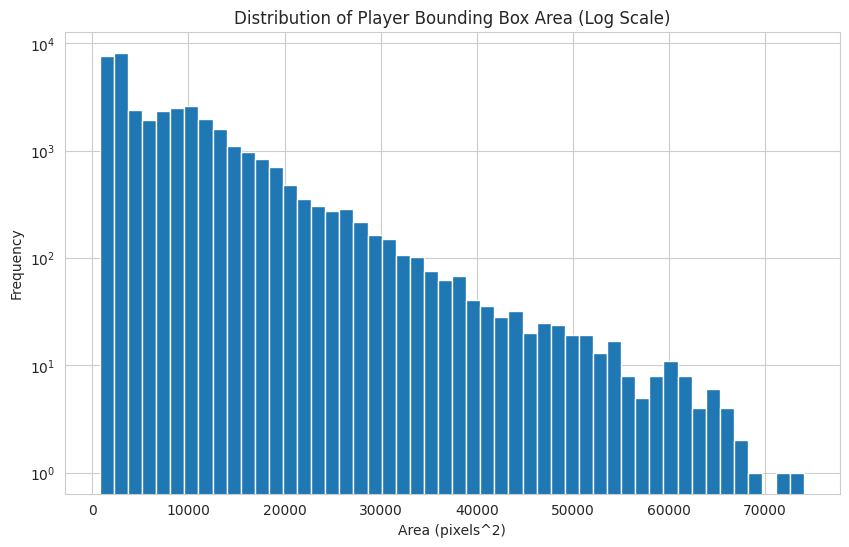

In [38]:
player_anns['area'] = player_anns['bbox'].apply(lambda x: x[2] * x[3])

plt.figure(figsize=(10, 6))
plt.hist(player_anns['area'], bins=50, log=True)
plt.title('Distribution of Player Bounding Box Area (Log Scale)')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Frequency')
plt.show()

### 4.2. キーポイントの数

各選手に対して通常いくつのポーズキーポイントがアノテーションされているかを分析します。

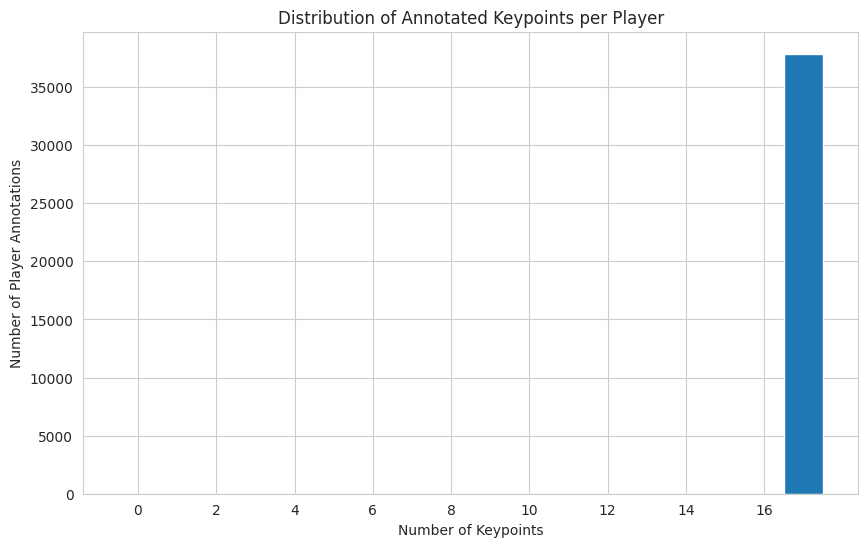

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(player_anns['num_keypoints'], bins=range(0, player_anns['num_keypoints'].max() + 2), align='left')
plt.title('Distribution of Annotated Keypoints per Player')
plt.xlabel('Number of Keypoints')
plt.ylabel('Number of Player Annotations')
plt.xticks(range(0, player_anns['num_keypoints'].max() + 1, 2))
plt.grid(True)
plt.show()

## 5\. 統合分析

### 5.1. 画像ごとのアノテーション数

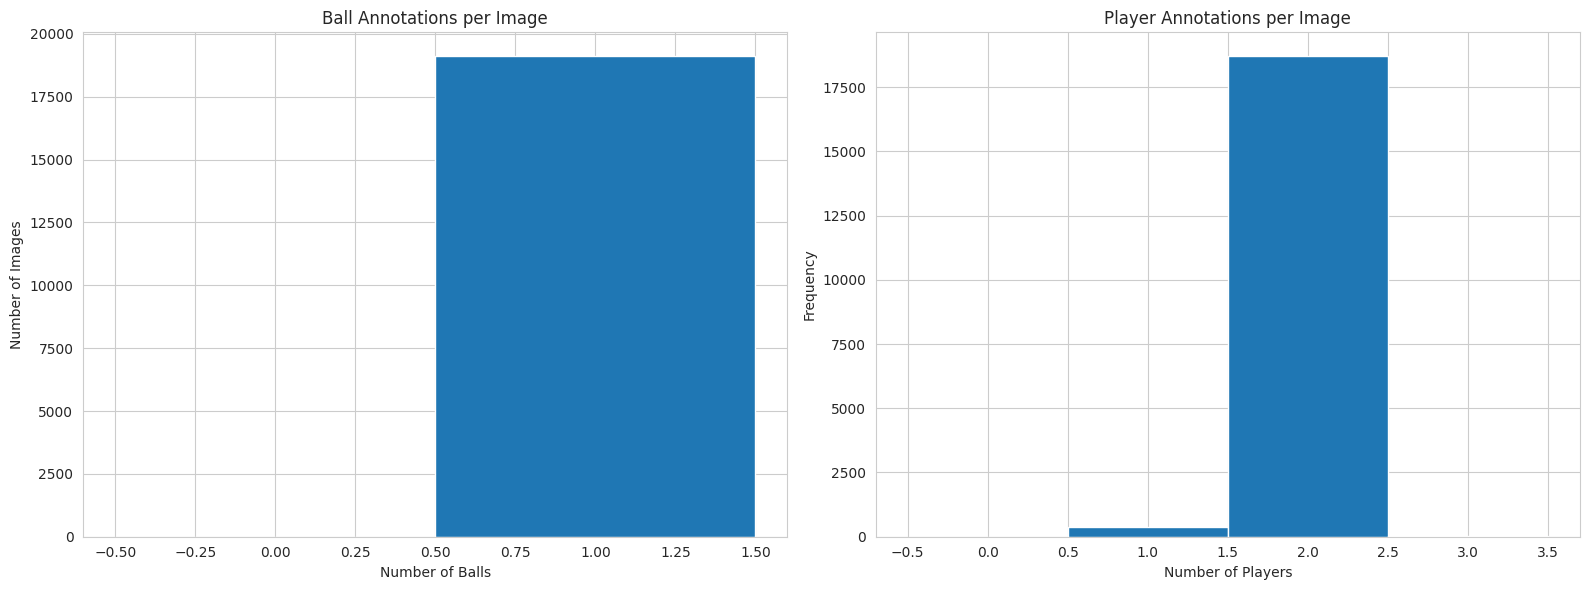

In [40]:
ann_per_image = annotations_df.groupby('image_id')['category_id'].value_counts().unstack(fill_value=0)
ann_per_image.columns = [coco_data['categories'][cat_id-1]['name'] for cat_id in ann_per_image.columns]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ann_per_image['ball'].plot(kind='hist', ax=axes[0], bins=range(ann_per_image['ball'].max() + 2), align='left')
axes[0].set_title('Ball Annotations per Image')
axes[0].set_xlabel("Number of Balls")
axes[0].set_ylabel("Number of Images")

ann_per_image['player'].plot(kind='hist', ax=axes[1], bins=range(ann_per_image['player'].max() + 2), align='left')
axes[1].set_title('Player Annotations per Image')
axes[1].set_xlabel("Number of Players")

plt.tight_layout()
plt.show()

## 6\. 可視化

最後に、ランダムなサンプル画像をすべてのアノテーションとともに可視化します。

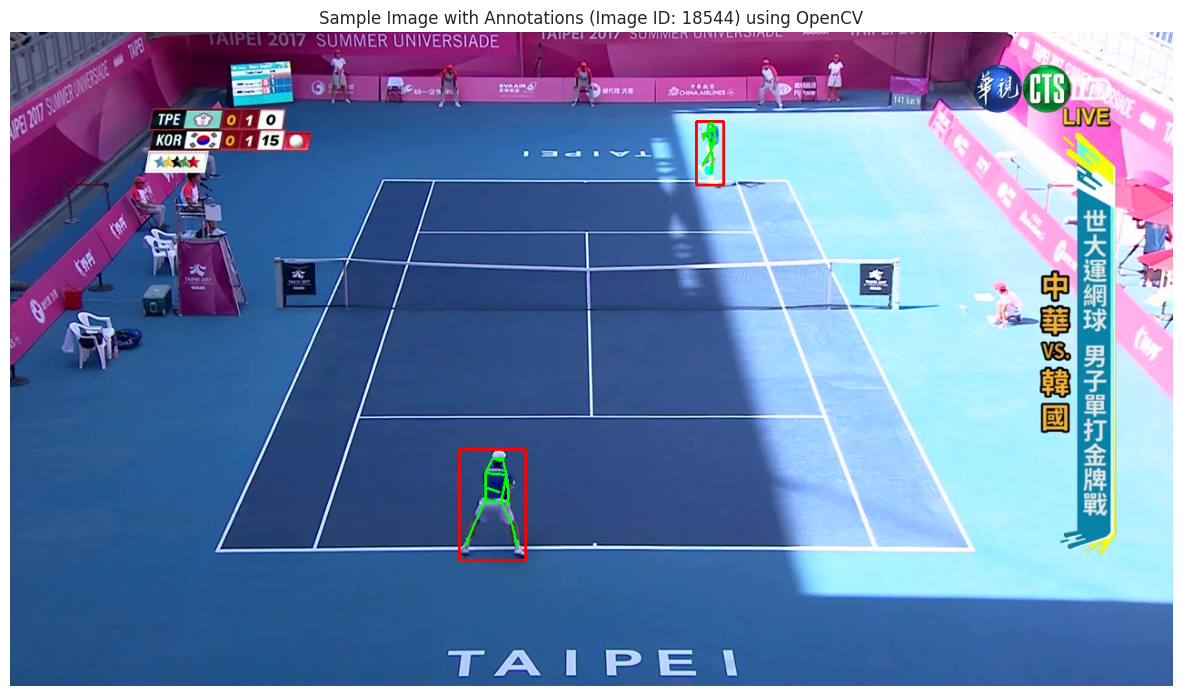

In [41]:
# 元のコードに含まれるヘルパー関数はそのまま使用します
def get_category_info(category_id, categories):
    """カテゴリIDに対応するカテゴリ情報を取得"""
    for cat in categories:
        if cat['id'] == category_id:
            return cat
    return None

def draw_annotations_with_cv2(image_id, images_df, annotations_df, categories, image_dir):
    """
    cv2 を使用して画像にアノテーションを描画する関数
    """
    # 画像情報を取得
    image_info = images_df[images_df["id"] == image_id].iloc[0]
    # cv2.imread は文字列パスを引数に取るため、Pathオブジェクトを変換
    image_path = str(image_dir / image_info["original_path"])
    
    # cv2で画像を読み込む (画像はBGR形式のNumpy配列として読み込まれる)
    image = cv2.imread(image_path)
    
    # 画像の読み込みに失敗した場合のエラーハンドリング
    if image is None:
        print(f"Error: Image not found at {image_path}")
        return None

    # 対象画像の全アノテーションを取得
    img_annotations = annotations_df[annotations_df["image_id"] == image_id]

    for _, ann in img_annotations.iterrows():
        cat_info = get_category_info(ann['category_id'], categories)
        cat_name = cat_info['name']
        
        if cat_name == 'ball':
            # キーポイント (円) を描画
            x, y, v = ann['keypoints']
            if v > 0:  # 可視性がある場合のみ描画
                # cv2.circle(image, center, radius, color_bgr, thickness)
                # Cyan: (B:255, G:255, R:0), thickness=-1 は塗りつぶし
                cv2.circle(image, (int(x), int(y)), 5, (255, 255, 0), -1)
            
            # バウンディングボックス (矩形) を描画
            bx, by, bw, bh = [int(c) for c in ann['bbox']]
            # cv2.rectangle(image, pt1, pt2, color_bgr, thickness)
            pt1 = (bx, by)
            pt2 = (bx + bw, by + bh)
            cv2.rectangle(image, pt1, pt2, (255, 255, 0), 1)  # Cyan, thickness=1

        elif cat_name == 'player':
            # バウンディングボックス (矩形) を描画
            bx, by, bw, bh = [int(c) for c in ann['bbox']]
            pt1 = (bx, by)
            pt2 = (bx + bw, by + bh)
            # Red: (B:0, G:0, R:255)
            cv2.rectangle(image, pt1, pt2, (0, 0, 255), 2)  # Red, thickness=2

            # ポーズキーポイントとスケルトン (線) を描画
            kpts = np.array(ann['keypoints']).reshape(-1, 3)
            skeleton = cat_info.get('skeleton', [])
            for start_idx, end_idx in skeleton:
                # スケルトンは1-based indexなので-1する
                x1, y1, v1 = kpts[start_idx - 1]
                x2, y2, v2 = kpts[end_idx - 1]
                if v1 > 0 and v2 > 0:  # 両方のキーポイントが可視の場合のみ線を描画
                    # cv2.line(image, pt1, pt2, color_bgr, thickness)
                    # Green: (B:0, G:255, R:0)
                    pt1_line = (int(x1), int(y1))
                    pt2_line = (int(x2), int(y2))
                    cv2.line(image, pt1_line, pt2_line, (0, 255, 0), 2)  # Green, thickness=2
    
    # 描画済みの画像 (NumPy配列) を返す
    return image

random_image_id = random.choice(images_df["id"])

# cv2を用いた新しい描画関数を呼び出す
annotated_image_bgr = draw_annotations_with_cv2(
    random_image_id, images_df, annotations_df, coco_data['categories'], IMAGE_DIR
)

# 画像が正常に処理された場合のみ表示
if annotated_image_bgr is not None:
    # Matplotlibで表示するために、BGR形式からRGB形式に変換
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)

    # Matplotlibで最終的な画像を表示
    plt.figure(figsize=(15, 10))
    plt.imshow(annotated_image_rgb)
    plt.title(f"Sample Image with Annotations (Image ID: {random_image_id}) using OpenCV")
    plt.axis("off")  # 軸を非表示にする
    plt.show()